## 1. Import required libraries and dependencies

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import cv2

## 2. Setting up GPU Growth

### It is to avoid Out of memory errors by setting GPU memory consumption growth

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
len(gpus) # 0 for non gpu machines and 1 for GPU machines

0

## 3. Create folder structures

In [3]:
# Setup Paths 

pos_path = os.path.join("data","positive") # For positive verifaction Image
neg_path = os.path.join("data","negative") # For negative verifaction Image
anch_path = os.path.join("data","anchor") # Actual image(Cam, and other input image)

In [3]:
pos_path,neg_path,anch_path

('data\\positive', 'data\\negative', 'data\\anchor')

In [6]:
# Create Folder Directory 

os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anch_path)

## 3.1 Untar Labelled Faces in wild dataset

In [7]:
# Uncompress Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [8]:
# Move the the extracted files to desired directory(Negative,positive,Anchor) - data/negative

for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw",directory)):
        ex_path = os.path.join("lfw",directory, file)
        new_path = os.path.join(neg_path,file)
        os.replace(ex_path,new_path)

## 3.2 Collective Positive and Anchor Classes

In [4]:
# Import UUID library to generate unique image names - Universally unique Identifiers
import uuid

In [10]:
# Establish Connection to webcam
capture = cv2.VideoCapture(0)

# loop through every single frame while cam is opened
while capture.isOpened(): 
    ret, frame = capture.read()  # return value and frame is actual image
    #cut down frame to 250 x 250 px
    frame = frame[30:40+240,300:550, :]
    # Collect Anchors 
    if cv2.waitKey(1) & 0XFF == ord("a"):
        #create the unique file path
        imgname = os.path.join(anch_path,f"{uuid.uuid1()}.jpg")
        cv2.imwrite(imgname, frame)
        
    
    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord("p"):
        imgname = os.path.join(pos_path,f"{uuid.uuid1()}.jpg")
        cv2.imwrite(imgname, frame)
    
        
    
    # show image to the screen
    cv2.imshow("Image Collection", frame)
    
    # Break the process
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break
        
# Release the webcam
capture.release()
# close the image show frame
cv2.destroyAllWindows()

In [15]:
#shape of the frame 
frame.shape # 3 is color channel - Red, Green, Blue and first two is dimension of image(Height and width)

(250, 250, 3)

In [14]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img,max_delta=0.02,seed =(1,2))
        img = tf.image.stateless_random_contrast(img,lower=0.6,upper=1,seed =(1,3))
        img = tf.image.stateless_random_flip_left_right(img,seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img,min_jpeg_quality=90,max_jpeg_quality=100,seed =(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img,lower=0.9,upper =1, seed=(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
        
    return data
        

In [15]:
img_path = os.path.join(anch_path, '9b8f2e05-a5e5-11ed-b2b3-f077c3b6bf84.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(anch_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [16]:
for file_name in os.listdir(os.path.join(pos_path)):
    img_path = os.path.join(pos_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## 3. Load And Preprocess Images

### 3.1 Get Image Directories

In [4]:
anchor = tf.data.Dataset.list_files(anch_path+"\*.jpg").take(1000)
positive = tf.data.Dataset.list_files(pos_path+"\*.jpg").take(1000)
negative = tf.data.Dataset.list_files(neg_path+"\*.jpg").take(1000)

In [5]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\f42f7608-9ed5-11ed-b5df-86400008abc7.jpg'

### 3.2 Preprocess Image - Scale and Resize

In [6]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(105,105))
    img = img / 255.0
    return img

In [7]:
img = preprocess('data\\anchor\\f2c52137-9ed5-11ed-b537-86400008abc7.jpg')
img.numpy().max()

0.9999667

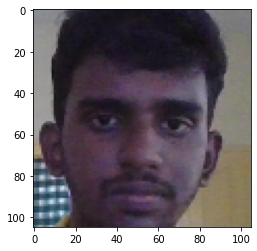

In [8]:
plt.imshow(img)

### 3.3 Create Labelled Dataset

In [9]:
# (Anchor, Positive) ---> 1,1,1,1,1
# (Anchor, Negative) ---> 0,0,0,0,0


positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()

In [11]:
exampple = samples.next()
exampple

(b'data\\anchor\\f37fa2cb-9ed5-11ed-b050-86400008abc7.jpg',
 b'data\\positive\\2ffc2bdd-a5e8-11ed-bb4e-f077c3b6bf84.jpg',
 1.0)

### 3.4Build Train and Test 

In [12]:
# Preprocess function for twindata(ie. [Anch,positive], [Anchor,negative])
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img), label)

In [13]:
res = preprocess_twin(*exampple)

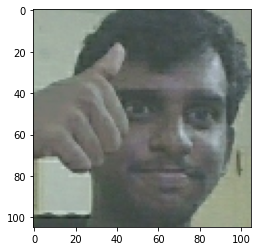

In [15]:
plt.imshow(res[1])

In [51]:
res[2]

1.0

In [16]:
# Build DataLoader Pipeline 

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
len(samples.next())


3

In [19]:
samp = samples.next()

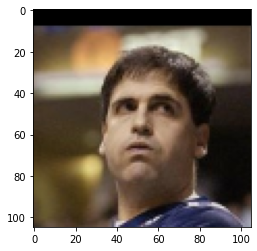

In [20]:
plt.imshow(samp[1])

In [21]:
# Training Partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8) # Effecitvely Starts preprocessing the next set of images so that bottleneck of neural network doesnot occour

In [22]:
# Testing Partition 

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 4. Modelling

### 4.1 Build Embedding Layer

In [23]:
def make_embedding():
    inp = Input(shape=(105,105,3),name="input_image")
    # First Block 
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    # Second Block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    # Third Block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    # Final block 
    c4 = c1 = Conv2D(256,(4,4),activation='relu')(m3)
    f1= Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    
    return Model(inputs=[inp],outputs=[d1],name="embedding")


In [24]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

### 4.2 Build Distance Layer 

In [25]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    # Simalarity Calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

### 4.3 Make Siamese Model

In [26]:
def make_siamese_model(): 
    
    # Anchor Image Input
    input_image = Input(name="input_img",shape=(105,105,3))
    # Validation Image Input
    validation_image = Input(name="validation_img",shape=(105,105,3))
    
    # Combine Siamese distance components 
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1,activation="sigmoid")(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')


In [27]:
siamese_model = make_siamese_model()

In [28]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 5. Training The Model

### 5.1 Setup loss and optimizer

In [29]:
binary_cross_loss = tf.losses.BinaryCrossentropy() # when the inputs to the loss function are not normalized

In [30]:
opt = tf.keras.optimizers.Adam(1e-4)

### 5.2 Establish CheckPoints

In [31]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model = siamese_model)

### 5.3 Step Function

In [32]:
# Compiles A function into a callable Tensorflow Graph
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape: 
        # Gradient Tape - Record operations for automatic differentiation
        # Get Anchor and positive/negative image
        x = batch[:2]
        # get Label
        y = batch[2]
        
        # Forward Pass 
        yhat =  siamese_model(x,training = True)
        # calculate loss
        loss = binary_cross_loss(y,yhat)
    print(loss)
    
    # Calculate Gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

### 5.4 Build training Loop

In [33]:
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print(f'\n {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [34]:
EPOCHS = 50 
train(train_data,EPOCHS)


 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
88/88 [==============================] - 2870s 33s/step
0.08415807 0.82792664 0.9832496

 2/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2921s 33s/step
0.001918156 0.98717946 1.0

 3/50
88/88 [==============================] - 2752s 31s/step
0.0016302831 0.995671 0.99710983

 4/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2862s 33s/step
0.013909836 0.9956522 1.0

 5/50
88/88 [==============================] - 2839s 32s/step
0.19952373 0.99710566 1.0

 6/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2751s 31s/step
4.7491005e-05 1.0 1.0

 7/50
88/88 [==============================] - 2841s 32s/step
0.03228686 0.9985896 1.0

 8/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2877s 33s/step
0.00488293 0.99717915 1.0

 9/50
88/88 [==============================] - 2853s 32s/step
0.0048988922 1.0 1.0

 10/50
1/1 [==============================] - 3s 3s/step


88/88 [==============================] - 2353s 27s/step
0.00059249107 1.0 1.0

 11/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2267s 26s/step
0.00038513748 1.0 1.0

 12/50
88/88 [==============================] - 2331s 26s/step
2.235183e-06 1.0 1.0

 13/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2277s 26s/step
0.003572853 1.0 1.0

 14/50
88/88 [==============================] - 2275s 26s/step
5.8859666e-07 1.0 1.0

 15/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2264s 26s/step
0.00088412 1.0 1.0

 16/50
88/88 [==============================] - 2264s 26s/step
2.2053775e-06 1.0 1.0

 17/50
1/1 [==============================] - 3s 3s/step


88/88 [==============================] - 2246s 26s/step
2.804669e-05 1.0 1.0

 18/50
88/88 [==============================] - 2281s 26s/step
3.6731685e-06 1.0 1.0

 19/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2261s 26s/step
5.2154075e-08 1.0 1.0

 20/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2269s 26s/step
4.8986203e-05 1.0 1.0

 21/50
88/88 [==============================] - 2274s 26s/step
1.9371628e-06 1.0 1.0

 22/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2261s 26s/step
3.2633675e-06 1.0 1.0

 23/50
88/88 [==============================] - 2261s 26s/step
0.0001238601 1.0 1.0

 24/50
1/1 [==============================] - 3s 3s/step


88/88 [==============================] - 2268s 26s/step
0.00032345124 1.0 1.0

 25/50
88/88 [==============================] - 2257s 26s/step
5.4210053e-05 1.0 1.0

 26/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2253s 26s/step
1.55055e-05 1.0 1.0

 27/50
88/88 [==============================] - 2291s 26s/step
3.1601143e-05 1.0 1.0

 28/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 3510s 40s/step
1.2517004e-06 1.0 1.0

 29/50
88/88 [==============================] - 2388s 27s/step
7.4505815e-09 1.0 1.0

 30/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2290s 26s/step
7.035533e-05 1.0 1.0

 31/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2328s 26s/step
2.7865476e-06 1.0 1.0

 32/50
88/88 [==============================] - 2260s 26s/step
7.6741213e-07 1.0 1.0

 33/50
1/1 [==============================] - 3s 3s/step


88/88 [==============================] - 2262s 26s/step
3.0059102e-05 1.0 1.0

 34/50
88/88 [==============================] - 2259s 26s/step
6.7131227e-06 1.0 1.0

 35/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2261s 26s/step
1.3530809e-05 1.0 1.0

 36/50
88/88 [==============================] - 2261s 26s/step
7.346481e-06 1.0 1.0

 37/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2337s 27s/step
4.2289183e-05 1.0 1.0

 38/50
88/88 [==============================] - 2266s 26s/step
1.3240381e-05 1.0 1.0

 39/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2256s 26s/step
1.3485583e-06 1.0 1.0

 40/50
88/88 [==============================] - 2295s 26s/step
7.03679e-05 1.0 1.0

 41/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 2268s 26s/step
1.4410249e-05 1.0 1.0

 42/50
1/1 [==============================] - 3s 3s/step


88/88 [==============================] - 2272s 26s/step
4.5448607e-07 1.0 1.0

 43/50
88/88 [==============================] - 2301s 26s/step
2.1422251e-05 1.0 1.0

 44/50
1/1 [==============================] - 3s 3s/step


88/88 [==============================] - 2248s 26s/step
3.099463e-06 1.0 1.0

 45/50
88/88 [==============================] - 1732s 20s/step
1.4901163e-08 1.0 1.0

 46/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 1745s 20s/step
8.890206e-05 1.0 1.0

 47/50
88/88 [==============================] - 1643s 19s/step
4.0768773e-05 1.0 1.0

 48/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 1612s 18s/step
0.0 1.0 1.0

 49/50
88/88 [==============================] - 1635s 19s/step
1.7881402e-07 1.0 1.0

 50/50
1/1 [==============================] - 2s 2s/step


88/88 [==============================] - 1627s 18s/step
1.2665993e-07 1.0 1.0


### 5.5 Train The model

## 6. Evaluating Model

- Precision Demonstrates What Portion of positive identifications were actually correct. 
- Recall shows what portion were identified correctly

In [35]:
# Import Metric Calculations
from tensorflow.keras.metrics import Precision, Recall


In [36]:
# Batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [37]:
# Make Predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[1.0000000e+00],
       [9.9932140e-01],
       [3.2045961e-07],
       [9.9999857e-01],
       [1.0000000e+00],
       [2.4344851e-07],
       [1.0444727e-08],
       [9.9999893e-01],
       [5.3738187e-09],
       [1.0000000e+00],
       [2.2821632e-07],
       [9.9992597e-01],
       [9.9999958e-01],
       [1.0000000e+00],
       [5.9333605e-10],
       [1.2896036e-06]], dtype=float32)

In [38]:
[1 if prediction >0.5 else 0 for prediction in y_hat]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0]

In [39]:
y_true

array([1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

### 6.3 Calculate metrics

In [40]:
# Creating Metric object
m = Recall()
m.update_state(y_true,y_hat)

m.result().numpy()

1.0

In [41]:
m= Precision()

m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [42]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input,test_val])
    r.update_state(y_true,yhat)
    p.update_state(y_true,yhat)
    
print(r.result().numpy(),p.result().numpy())

1/1 [==============================] - 1s 803ms/step
1.0 1.0


### 6.4 Visualize Result 

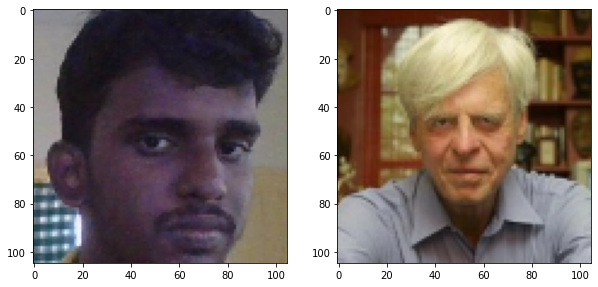

In [44]:
# Set Plot Size 
plt.figure(figsize=(10,8))

# Set first subplot 
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second Subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

plt.show()

## 7.Save Model

In [45]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [46]:
L1Dist

__main__.L1Dist

In [47]:
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [48]:
siamese_model.predict([test_input, test_val])


1/1 [==============================] - 2s 2s/step


array([[1.0000000e+00],
       [1.2849210e-07],
       [2.4738557e-07],
       [8.1274840e-07],
       [4.2189947e-07],
       [1.0090720e-08],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [49]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 8.Real Time Testing

### 8.1 Verification Function 

In [55]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_images.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [59]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_images.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 226ms/step
True


In [56]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [60]:
np.sum(np.squeeze(results)> 0.9)

24

In [61]:
results

[array([[0.9944827]], dtype=float32),
 array([[0.9802745]], dtype=float32),
 array([[0.9802745]], dtype=float32),
 array([[0.9930038]], dtype=float32),
 array([[0.9883006]], dtype=float32),
 array([[0.973136]], dtype=float32),
 array([[0.9895051]], dtype=float32),
 array([[0.9652627]], dtype=float32),
 array([[0.9808615]], dtype=float32),
 array([[0.13384028]], dtype=float32),
 array([[0.00106381]], dtype=float32),
 array([[0.95048285]], dtype=float32),
 array([[0.9969144]], dtype=float32),
 array([[0.22618784]], dtype=float32),
 array([[0.9998839]], dtype=float32),
 array([[0.9975625]], dtype=float32),
 array([[0.33713287]], dtype=float32),
 array([[0.37601295]], dtype=float32),
 array([[0.15955651]], dtype=float32),
 array([[0.14812216]], dtype=float32),
 array([[0.01483386]], dtype=float32),
 array([[0.14666776]], dtype=float32),
 array([[0.10816846]], dtype=float32),
 array([[0.19987063]], dtype=float32),
 array([[0.9990757]], dtype=float32),
 array([[0.9999393]], dtype=float32),
 